#TODO:

**1.Обучить классификатор на старых данных, проверить на новых (новые=старые+26недель).**

**2.Применить PCA без снижения размерности. Повторить п.1.**

**3.Оставить наиболее важные факторы. Повторить с п.1.**

**4.Снизить размерность PCA. Повторить п.1.**

**5.Сгладить ряды. Повторить п.1.**

**6.Сгладить ряды. Повторить п.4.**

**7.Проделать п.1 для новых факторов.**

#Описание
Данная тетрадка содержит описание данных задачи.

In [122]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#time_series.csv
Данный файл содержит временные ряды истории обращений к файлам за 78 недель и их метки. Метка **0** - популярные файлы, **1** - непопулярные файлы. Важно надежно определять непопулярные файлы.


###Чтение файла.

In [123]:
time_series = pd.read_csv('new_features.csv')
time_series.irow(range(1,5))

,Unnamed: 0,Name,last-zeros,inter_max,nb_peaks,inter_mean,inter_std,inter_rel,mass_center,mass_center_sqr,mass_moment,r_moment,log_total_usage,Label
1,1,/LHCb/Collision10/Beam3500GeV-VeloClosed-MagDo...,64,0,1,0,0,0,16,116224,0,0,6.120297,0
2,2,/LHCb/Collision10/Beam3500GeV-VeloClosed-MagDo...,73,1,2,1,0,0,6,31650,474,0,6.563856,1
3,3,/LHCb/Collision10/Beam3500GeV-VeloClosed-MagDo...,55,0,1,0,0,0,25,95000,0,0,5.030438,1
4,4,/LHCb/Collision10/Beam3500GeV-VeloClosed-MagDo...,55,0,1,0,0,0,25,108125,0,0,5.159055,1


In [131]:
columns = time_series.columns[2:-1]
columns

Index([u'last-zeros', u'inter_max', u'nb_peaks', u'inter_mean', u'inter_std', u'inter_rel', u'mass_center', u'mass_center_sqr', u'mass_moment', u'r_moment', u'log_total_usage'], dtype='object')

###Примеры временных рядов

In [3]:
periods_str = [str(i) for i in range(1,79)]
periods = range(1,79)

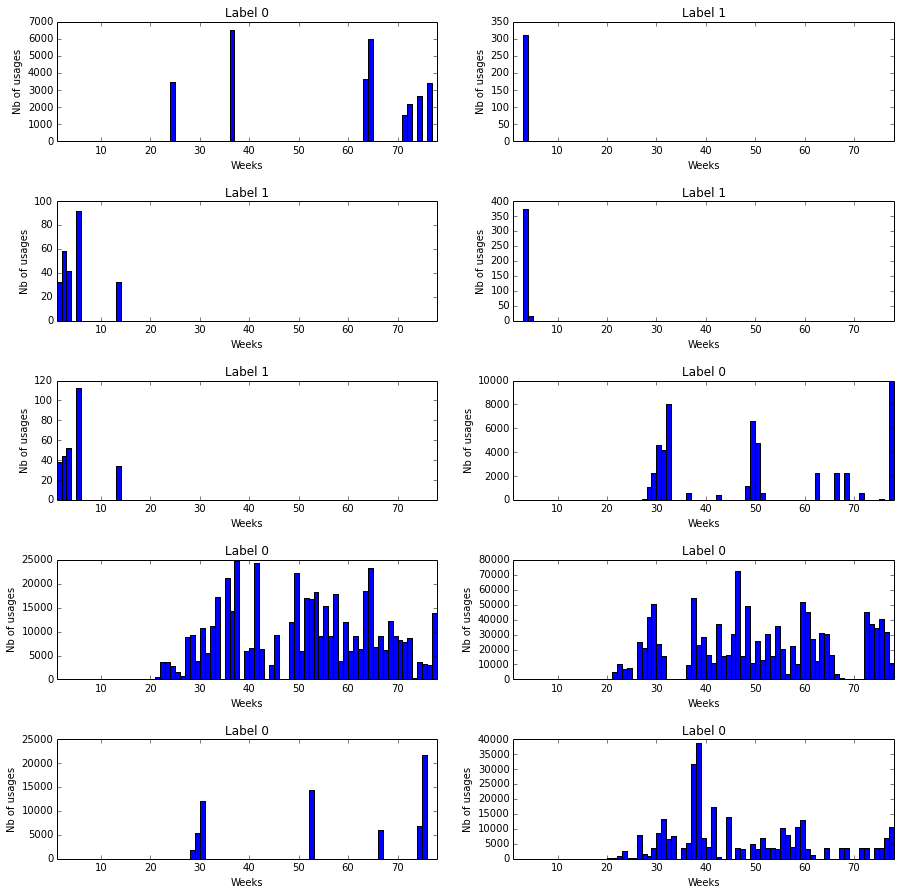

In [4]:
plt.figure(figsize=(15,15))
plt.subplots_adjust( hspace=.5)
for i in range(48,58):#менять тут
    one_time_serie = time_series[periods_str].irow(i).values
    one_label = str(time_series['Label'].irow(i))
    plt.subplot(5,2,i-47)#и тут
    plt.bar(periods, one_time_serie, width=1, bottom=0)
    plt.xlim(1,78)
    plt.xlabel('Weeks')
    plt.ylabel('Nb of usages')
    plt.title('Label '+one_label)
plt.show()

###Гистограммы для каждого фактора
В log10 масштабе.

#Проекция на 2D
Для интуитивного представления о разделении двух классов

In [132]:
X_ts = time_series[columns].values
Y_ts = time_series['Label'].values

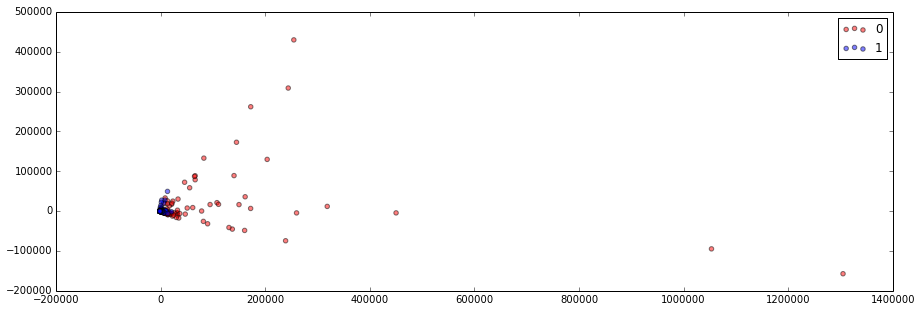

In [5]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_ts_2d = pca.fit(X_ts, Y_ts).transform(X_ts)

plt.figure(figsize=(15,5))
plt.scatter(X_ts_2d[Y_ts==0, 0], X_ts_2d[Y_ts==0, 1], c='r', label='0', alpha=0.5)
plt.scatter(X_ts_2d[Y_ts==1, 0], X_ts_2d[Y_ts==1, 1], c='b', label='1', alpha=0.5)
plt.legend(loc='best')
plt.show()

###Снижение размерности данных

In [106]:
pca_red = PCA(n_components=20)
X_ts_red = pca_red.fit(X_ts, Y_ts).transform(X_ts)

###Ядерное сглаживание Надарая-Ватсона

In [107]:
from kernel_regression import KernelRegression

def Kernel_smoothing(X, periods):
    X_ker = X.copy()
    for i in range(0, X.shape[0]):
        kr = KernelRegression(kernel="rbf", gamma=np.logspace(-2, 2, 10))
        x_one_kr = kr.fit(periods, X[i,:]).predict(periods)
        X_ker[i,:] = x_one_kr
    return X_ker

In [108]:
X_ts_ker = Kernel_smoothing(X_ts_red, np.array([[i] for i in range(1, 79)[-20:]]))

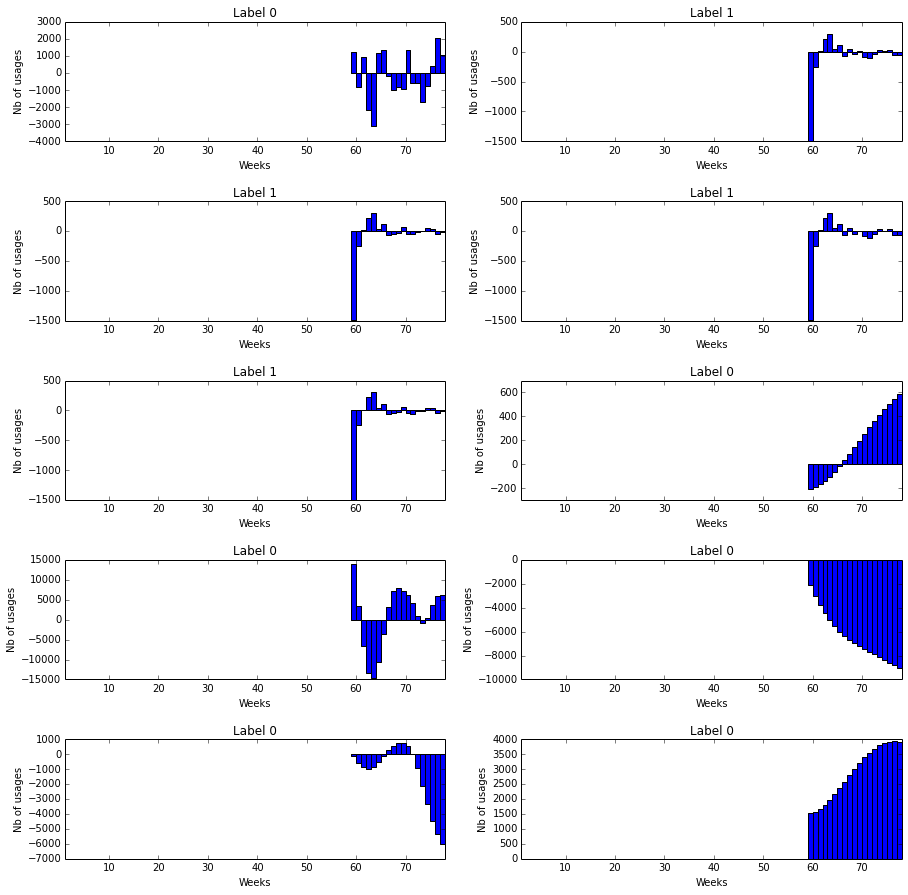

In [109]:
plt.figure(figsize=(15,15))
plt.subplots_adjust( hspace=.5)
for i in range(48,58):#менять тут
    one_time_serie = X_ts_ker[i,:]
    one_label = str(Y_ts[i])
    plt.subplot(5,2,i-47)#и тут
    plt.bar(periods[-20:], one_time_serie, width=1, bottom=0)
    plt.xlim(1,78)
    plt.xlabel('Weeks')
    plt.ylabel('Nb of usages')
    plt.title('Label '+one_label)
plt.show()

#Применение классификатора

In [128]:
from sklearn.cross_validation import KFold

def Indexes_inverse(indexes):
    new_indexes = range(0,len(indexes))
    for i in range(0, len(indexes)):
        new_indexes[int(indexes[i])]=i
    return new_indexes

def KFold_predict_proba(estimator, X, Y, k):
    indexes = np.array([])
    Y_predict_proba = np.empty((0,2))
    kfold = KFold(n=X.shape[0], n_folds=k, random_state=42, shuffle=True)
    for train_index, test_index in kfold:
        X_train, X_test = X[train_index], X[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]
        indexes = np.concatenate((indexes, test_index), axis=0)
        estimator.fit(X_train, Y_train)
        Y_predict_proba_test = estimator.predict_proba(X_test)
        Y_predict_proba = np.concatenate((Y_predict_proba, Y_predict_proba_test), axis=0)
    new_indexes = Indexes_inverse(indexes)
    return Y_predict_proba[list(new_indexes)]

In [134]:
%%time
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier

estimator_ts = GradientBoostingClassifier(learning_rate=0.02, n_estimators=2500, max_depth=6, subsample=0.8)
Y_ts_proba = KFold_predict_proba(estimator=estimator_ts, X=X_ts, Y=Y_ts, k=3)

CPU times: user 1min 6s, sys: 83 ms, total: 1min 6s
Wall time: 1min 6s


Значимость признаков

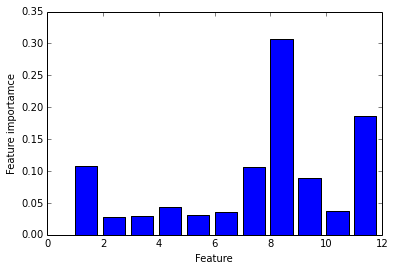

In [135]:
feature_imp = estimator_ts.feature_importances_
plt.bar(range(1,len(columns)+1), feature_imp)
plt.xlabel('Feature')
plt.ylabel('Feature importamce')
plt.show()

Строим ROC кривую.

ROC AUC is  0.913111623864


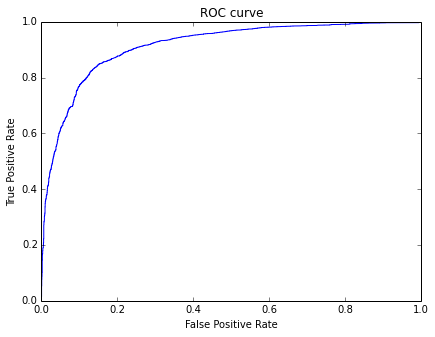

In [136]:
from sklearn.metrics import roc_curve, auc

fpr_ts, tpr_ts, _ = roc_curve(Y_ts, Y_ts_proba[:,1], pos_label=None, sample_weight=None)
roc_auc_ts = auc(fpr_ts, tpr_ts)

plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
plt.plot(fpr_ts, tpr_ts)
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
print 'ROC AUC is ', roc_auc_ts

Запишем baseline 1.

In [137]:
# bs1 = pd.DataFrame()
# bs1['fpr_ts'] = fpr_ts
# bs1['tpr_ts'] = tpr_ts
# bs1.to_csv('baseline1.csv')

###Тест на новых данных

In [138]:
data_test = pd.read_csv('new_features_910days.csv')
data_test.irow(range(1,5))

,Unnamed: 0,Name,last-zeros,inter_max,nb_peaks,inter_mean,inter_std,inter_rel,mass_center,mass_center_sqr,mass_moment,r_moment,log_total_usage,Label,Target
1,1,/LHCb/Collision10/Beam3500GeV-VeloClosed-MagDo...,88,10,2,10.0,0.000000,0.000000,14,570504,54576,22,7.786136,1,0
2,2,/LHCb/Collision10/Beam3500GeV-VeloClosed-MagDo...,89,12,5,4.0,4.636809,1.159202,2,56412,17464,3,8.646114,1,0
3,3,/LHCb/Collision10/Beam3500GeV-VeloClosed-MagDo...,86,13,6,3.8,4.621688,1.216234,6,352375,160435,33,8.472405,1,0
4,4,/LHCb/Collision10/Beam3500GeV-VeloClosed-MagDo...,49,3,2,3.0,0.000000,0.000000,54,19587762,6174,0,8.800867,1,0


In [139]:
periods_test = [str(i) for i in range(27, 105)]
X_test = data_test[columns].values
Y_test = data_test['Label'].values

In [117]:
X_test_red = pca_red.transform(X_test)

In [118]:
X_test_ker = Kernel_smoothing(X_test_red, np.array([[i] for i in range(27, 105)[-20:]]))

In [140]:
%%time

Y_test_proba = estimator_ts.predict_proba(X_test)

CPU times: user 424 ms, sys: 703 µs, total: 424 ms
Wall time: 424 ms


###Сравнение с baselines.

In [141]:
baseline1 = pd.read_csv('baseline1.csv')

ROC AUC is  0.913111623864


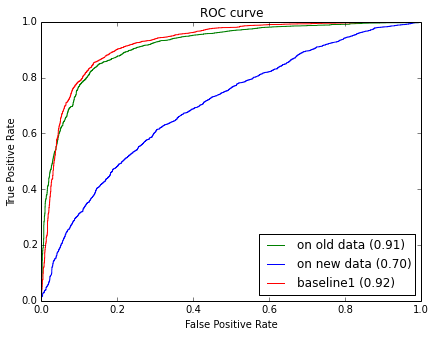

In [142]:
from sklearn.metrics import roc_curve, auc

fpr_ts, tpr_ts, _ = roc_curve(Y_ts, Y_ts_proba[:,1], pos_label=None, sample_weight=None)
roc_auc_ts = auc(fpr_ts, tpr_ts)

fpr_test, tpr_test, _ = roc_curve(Y_test, Y_test_proba[:,1], pos_label=None, sample_weight=None)
roc_auc_test = auc(fpr_test, tpr_test)

roc_auc_base = auc(baseline1['fpr_ts'].values, baseline1['tpr_ts'].values)

plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
plt.plot(fpr_ts, tpr_ts, label='on old data (%.2f)' % roc_auc_ts, c='g')
plt.plot(fpr_test, tpr_test, label='on new data (%.2f)' % roc_auc_test, c='b')
plt.plot(baseline1['fpr_ts'].values, baseline1['tpr_ts'].values, label='baseline1 (%.2f)' % roc_auc_base, c='r')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='best')
print 'ROC AUC is ', roc_auc_ts